# City of Boston Payroll Analysis
Salary data is available for City of Boston employees from at least 2011 to 2016.  Roughly 20,000 employees and salaries are classified by department, job title, “regular” or “overtime”, zip code and a few other criteria.

In [1]:
# import modules
import numpy as np
import pandas as pd
import re, os, glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# read file(s)
path = os.getcwd()                    
all_files = glob.glob(os.path.join(path, "employee*.csv"))  

column_names = ['name', 'department', 'title', 'regular', 'retro', 'other', 'overtime', 'injured',\
                'detail', 'quinn', 'total', 'zipcode']
df_from_each_file = (pd.read_csv(f, encoding = "ISO-8859-1", header=0, names=column_names, \
                                 index_col=None).assign(year=f) for f in all_files)  
earnings   = pd.concat(df_from_each_file, ignore_index=True)

## Data Cleaning

A complete set of names/employees, departments, titles and total earnings are availble for the years 2011-2016. Some fields are blank due to no earnings in that particular category. 5 zipcodes are missing. 

In [3]:
print(earnings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130299 entries, 0 to 130298
Data columns (total 13 columns):
name          130299 non-null object
department    130299 non-null object
title         130299 non-null object
regular       129716 non-null object
retro         108669 non-null object
other         121098 non-null object
overtime      114943 non-null object
injured       109631 non-null object
detail        110677 non-null object
quinn         109543 non-null object
total         130299 non-null object
zipcode       130294 non-null object
year          130299 non-null object
dtypes: object(13)
memory usage: 12.9+ MB
None


In [4]:
# extract year from file name
earnings['year'] = earnings['year'].replace({'\D':''}, regex=True)
earnings['year'] = earnings['year'].str[-4:]  # remove any numbers from file path

# keep first 5 digits of zipcode
earnings['zipcode'] = earnings['zipcode'].str[:5].astype('category')

# missing zipcodes
earnings = earnings.sort_values(by='name').fillna(method='ffill')

# convert number strings to numeric dtype
number_columns = ['regular', 'retro', 'other', 'overtime', 'injured', 'detail', 'quinn', 'total']
earnings[number_columns] = earnings[number_columns].replace({'\$': '', ',': ''}, regex=True)\
                                .apply(pd.to_numeric, errors='coerce').fillna(0, axis=1)

In [5]:
earnings.insert(13, 'new_dept', np.nan)
earnings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130299 entries, 21210 to 79724
Data columns (total 14 columns):
name          130299 non-null object
department    130299 non-null object
title         130299 non-null object
regular       130299 non-null float64
retro         130299 non-null float64
other         130299 non-null float64
overtime      130299 non-null float64
injured       130299 non-null float64
detail        130299 non-null float64
quinn         130299 non-null float64
total         130299 non-null float64
zipcode       130299 non-null category
year          130299 non-null object
new_dept      0 non-null float64
dtypes: category(1), float64(9), object(4)
memory usage: 14.2+ MB


There are 2087 unique job titles - a plausible number. Interestingly there are 1747 unique department names. According to the city's website, there are actually only 72 departments. 

In [6]:
print('Number of job titles:', len(earnings.title.unique()))
print('Number of departments:', len(earnings.department.unique()))

Number of job titles: 2087
Number of departments: 1747


A closer look at the job titles shows some data cleaning might be helpful as well:

In [7]:
police_titles = earnings.title.loc[(earnings.department == 'Boston Police Department') & \
                                   (earnings.title.str.startswith('Police Off')) & \
                                   (earnings.year == '2016')]
police_department = earnings.title.loc[(earnings.department == 'Boston Police Department') & \
                                       (earnings.year == '2016')]
print('Number of unique job titles in police department (2016):', len(set(police_department)))
print(police_titles.value_counts())

Number of unique job titles in police department (2016): 178
Police Officer                    1279
Police Offc Comm Serv Offc 3$8      52
Police Offc Mobile Offc 2$6         47
Police Offc Acad Instr 2$6          28
Police Offc/FgrPrt Ev Tch 4$10      23
Police Offc Canine 2$6              18
Police Offc/Juvenile Offc 4$10      18
Police Officer Hdq Dispatch         14
Police Offc Harborboat 3$8          13
Police Offc Hackney Invest 3$8      13
Police Offc/Auto Invest 4$10        10
Police Offc Canine Offc 2$6         10
Police Offc/Bomb Squad               9
Police Offc Bomb Squad               6
Police Offc Ballistician 4$10        6
Police Offc/Hosp Liaison 4$10        5
Police Officer Harborboat 3$8        4
Police Officer Mobile Oper 2$6       2
Police Offc Breath $13.50            1
Name: title, dtype: int64


Note: $ symbols are possible errors in the dataset, but don't seem to affect the other columns.

In [8]:
departments = earnings.groupby('department')['department'].agg('count').nlargest(20)
departments

department
Boston Public Schools             24459
Boston Police Department          12195
Teacher                           10938
Boston Fire Department             6728
Police Officer                     2657
Paraprofessional                   2322
Boston Cntr - Youth & Families     2244
Boston Public Library              2007
BPS Substitute Teachers/Nurs       1910
Substitute Teacher                 1882
Public Works Department            1845
Fire Fighter                       1734
BPS Special Education              1486
Parks Department                   1136
BPS Facility Management            1123
BPS Transportation                  985
Inspectional Services Dept          928
Lunch Hour Monitors                 808
Property Management                 782
Part-Time Cafeteria Attendant       777
Name: department, dtype: int64

In [9]:
earnings['new_dept'] = earnings['department']
bps = ['Teacher', 'Substitute Teacher', 'Paraprofessional', 'Cab Monitor', 'Tech Boston Academy', 'Sub Teacher - Retiree',\
       'One to One Para', 'Surround Care Paraprofessional', 'School Traffic Supv', 'Lunch Hour Monitors', \
       'Prin Clerk/School Sec 19', 'Henderson Elementary', 'UP Academy Dorchester', 'Umana Middle', \
       'SpEd Support Svcs Coordinator', 'Frederick Pilot Middle', 'King K-8', 'Kilmer K-8', 'Boston Public Schools']
earnings['new_dept'] = np.where(earnings.department.astype(str).str[:3] == 'BPS', 'Boston Public Schools', earnings.new_dept)
earnings['new_dept'] = np.where(earnings.department.isin(bps), 'Boston Public Schools', earnings.new_dept)

print(earnings[['department','new_dept']].tail(20))

                    department               new_dept
11184    Boston Public Schools  Boston Public Schools
11257    Boston Public Schools  Boston Public Schools
75111           ABA Specialist         ABA Specialist
92128    BPS Special Education  Boston Public Schools
11570    Boston Public Schools  Boston Public Schools
47714              Cab Monitor  Boston Public Schools
50286              Cab Monitor  Boston Public Schools
1409       Property Management    Property Management
23286      Property Management    Property Management
13765    Boston Public Schools  Boston Public Schools
119631      Veterans' Services     Veterans' Services
98059     BPS Charlestown High  Boston Public Schools
54789              Cab Monitor  Boston Public Schools
61219              Cab Monitor  Boston Public Schools
106779  BPS Counseling Service  Boston Public Schools
65027           Counselor (CC)         Counselor (CC)
107033              Kilmer K-8  Boston Public Schools
129081              Kilmer K

In [10]:
bps = earnings.title.loc[(earnings.department.str.startswith('Boston Public Schoo'))]
print(bps.value_counts())

Teacher                           10365
Paraprofessional                   2269
Substitute Teacher                 1513
Lunch Hour Monitors                 756
Part-Time Cafeteria Attendant       749
Cab Monitor                         571
Community Field Coordinator         313
Jr Cust/Nights                      310
Prin Clerk/School Sec 19            249
One to One Para                     240
Sub Teacher - Retiree               235
Nurse                               234
Sen Cust C                          225
Part-Time Custodian                 223
BPS Bi-Weekly 26 Leave              220
Summer BTU Para                     212
SpEd Support Svcs Coordinator       193
Surround Care Paraprofessional      175
Cluster Substitute                  167
Substitute Cafeteria Attendant      166
Hot Line Worker                     152
Specialist (BTU)                    136
Principal Elementary                135
Sen Cust C/Nights                   134
Jr Custodian                        134


Median total earnings by department:

      total payroll ($)
year                   
2011       1.297467e+09
2012       1.315063e+09
2013       1.384350e+09
2014       1.487853e+09
2015       1.551892e+09
2016       1.580210e+09


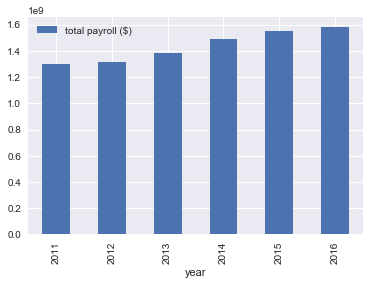

In [11]:
total_earnings = earnings.groupby(earnings['year'])['total'].agg(np.sum).reset_index().set_index('year').rename(columns={'total':'total payroll ($)'})
print(total_earnings)
total_earnings.plot(kind='bar')
plt.show()

In [12]:
salary = earnings.groupby(earnings['department'])['regular'].agg(np.median).nlargest(10)
print(salary)

department
DepFireChiefAdmn-AdvTechnician    183086.920
President                         178455.525
Dep Fire Chief Administration     172032.660
Chief of Support Services         170007.270
Deputy Superintendent             167158.025
Mayor                             164903.870
Supn (Bfd/Fad)                    163459.700
Supn-In Chief                     162513.590
District FireChiefAdmn-AdvTech    160967.545
Dep Fire Chief                    159629.990
Name: regular, dtype: float64


"Cab Monitors" (=bus monitors) earn at least \$21.73 per trip in 2018. How does someone earn only $2.14?

In [13]:
cab = earnings.loc[(earnings.title == 'Cab Monitor')]
# salary = cab.loc[(cab.total == min(cab.total))]
cab = cab.sort_values(by='total')
print(cab.total[:10])

118102    2.14
110239    2.50
122106    3.85
110599    4.38
113195    6.48
124690    6.53
129115    7.58
130140    8.05
118542    8.45
111246    8.82
Name: total, dtype: float64


## Residency Requirement
Boston city employees are required to live within city limits. The law is not strictly enforced and is confounded by state, federal and union regulations. 

https://www.boston.gov/departments/human-resources/residency-requirements-city-workers

https://www.bostonglobe.com/metro/2016/01/13/mayor-walsh-seeks-strengthen-boston-residency-requirement-with-caveat/ZyG8xmkOsu0dMHgITSUOKN/story.html

What does the distribution look like in 2016?

69 % of city employees live in Boston (2016).


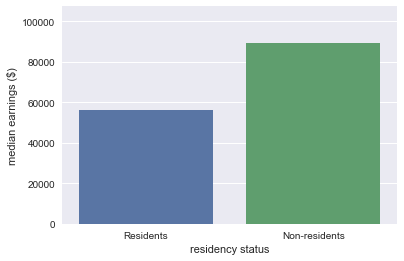

In [14]:
# Read in Boston zipcode list
boston_zips = pd.read_csv('boston-zipcodes.csv', names=['bzips'], header=None)
boston_zips = boston_zips.astype(str).apply(lambda x: '0' + x) # treat zipcodes as strings and add leading "0"

# define resident and non-resident employees
inzips = earnings.loc[(earnings.zipcode.isin(boston_zips.bzips) & (earnings.year == '2016'))]
outzips = earnings.loc[(~earnings.zipcode.isin(boston_zips.bzips) & (earnings.year == '2016'))]
residents = inzips.shape[0] /(inzips.shape[0] + outzips.shape[0]) * 100
print(int(residents), '% of city employees live in Boston (2016).')

# income distribution
in_earnings = inzips['total'].agg(np.median)
out_earnings = outzips['total'].agg(np.median)
zip_df = pd.DataFrame({'residency status': ['Residents', 'Non-residents'], 'median earnings ($)': [in_earnings, out_earnings]}, index=[0, 1])

# plot
sns.barplot(x='residency status', y='median earnings ($)', data=zip_df)
plt.margins(0.2)
plt.show()